In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.sparse as sp

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/recommender-system-2024-challenge-polimi/data_train.csv
/kaggle/input/recommender-system-2024-challenge-polimi/data_target_users_test.csv
/kaggle/input/recommender-system-2024-challenge-polimi/data_ICM_metadata.csv


# Github connection 

In [2]:
!pip install PyGithub

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 375.9/375.9 kB 10.2 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 856.7/856.7 kB 21.8 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 35.1 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [3]:
from kaggle_secrets import UserSecretsClient
secret_label = "Token"
token = UserSecretsClient().get_secret(secret_label)

! git clone https://{token}@github.com/LorenzoBozzoni/RecSys_Challenge_Polimi_2024.git

Cloning into 'RecSys_Challenge_Polimi_2024'...
remote: Enumerating objects: 201, done.
remote: Counting objects: 100% (201/201), done.
remote: Compressing objects: 100% (158/158), done.
remote: Total 201 (delta 49), reused 182 (delta 39), pack-reused 0 (from 0)
Receiving objects: 100% (201/201), 8.14 MiB | 28.25 MiB/s, done.
Resolving deltas: 100% (49/49), done.


In [4]:
from github import Github
from github import Auth

auth = Auth.Token(token)
g = Github(auth=auth)

repo = None
for r in g.get_user().get_repos():
    if r.name == 'RecSys_Challenge_Polimi_2024':
        repo = r
        print('Repository found')

Repository found


## Commit and push some specific file

In [5]:
def upload_file(filepath_kaggle, filepath_github, commit_message):
    try:
        contents = repo.get_contents(filepath_github)
        with open(filepath_kaggle, "rb") as file:
            repo.update_file(contents.path, commit_message, file.read(), contents.sha)
        print('Commit and push completed successfully')
    except Exception:
        with open(filepath_kaggle, "rb") as file:
            repo.create_file(filepath_github, commit_message, file.read())
        print(f'Exception {Exception} while trying to committing')

In [6]:
%cd /kaggle/working/RecSys_Challenge_Polimi_2024

/kaggle/working/RecSys_Challenge_Polimi_2024


/usr/local/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [7]:
!pip install h5py==3.1.0 tables==3.7.0
!pip install nltk==3.6.1 tqdm==4.59.0
! pip install lightfm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 371.4/371.4 kB 8.5 MB/s eta 0:00:0000:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... error
  error: subprocess-exited-with-error
  
  × pip subprocess to install backend dependencies did not run successfully.
  │ exit code: 1
  ╰─> [1217 lines of output]
           ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/3.6 MB ? eta -:--:--
           ━━━━━━━╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.7/3.6 MB 20.4 MB/s eta 0:00:01
           ━━━━━━━━━━━━━━━━━━━━╸━━━━━━━━━━━━━━━━━━━ 1.9/3.6 MB 27.7 MB/s eta 0:00:01
           ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 3.6/3.6 MB 35.5 MB/s eta 0:00:01
           ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 26.2 MB/s eta 0:00:00
           ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/7.3 MB ? eta -:--:--
           ━━━━━━━━━━━━━━━╸━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/7.3 MB 86.8 MB/s eta 0:00:01
           ━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [8]:
#upload_file('/kaggle/working/RecSys_Challenge_Polimi_2024/recsys-challenge-2024.ipynb', './recsys-challenge-2024.ipynb', 'adding github connection from kaggle')

# Data exploration 
## URM
The URM contains a user for each row and an item for each column

In [9]:
URM_all_dataframe = pd.read_csv("/kaggle/input/recommender-system-2024-challenge-polimi/data_train.csv")
URM_all_dataframe.head(10)

,user_id,item_id,data
0,0,0,1.0
1,0,2,1.0
2,0,120,1.0
3,0,128,1.0
4,0,211,1.0
5,0,232,1.0
6,0,282,1.0
7,0,453,1.0
8,0,458,1.0
9,0,491,1.0


In [10]:
print ("The number of interactions is {}".format(len(URM_all_dataframe)))

The number of interactions is 1764607


In [11]:
userID_unique = URM_all_dataframe["user_id"].unique()
itemID_unique = URM_all_dataframe["item_id"].unique()
n_users = len(userID_unique)
n_items = len(itemID_unique)
n_interactions = len(URM_all_dataframe)

print ("Number of items\t {}, Number of users\t {}".format(n_items, n_users))
print ("Max ID items\t {}, Max Id users\t {}\n".format(max(itemID_unique), max(userID_unique)))

Number of items	 38121, Number of users	 35736
Max ID items	 38120, Max Id users	 35735



In [12]:
mapped_id, original_id = pd.factorize(URM_all_dataframe["user_id"].unique())
user_original_ID_to_index = pd.Series(mapped_id, index=original_id)

mapped_id, original_id = pd.factorize(URM_all_dataframe["item_id"].unique())
item_original_ID_to_index = pd.Series(mapped_id, index=original_id)

In [13]:
original_item_ID = 292
print("New index for item {} is {}".format(original_item_ID, item_original_ID_to_index[original_item_ID]))
URM_all_dataframe.head(n=10)

New index for item 292 is 17024


,user_id,item_id,data
0,0,0,1.0
1,0,2,1.0
2,0,120,1.0
3,0,128,1.0
4,0,211,1.0
5,0,232,1.0
6,0,282,1.0
7,0,453,1.0
8,0,458,1.0
9,0,491,1.0


In [14]:
URM_all_dataframe["user_id"] = URM_all_dataframe["user_id"].map(user_original_ID_to_index)
URM_all_dataframe["item_id"] = URM_all_dataframe["item_id"].map(item_original_ID_to_index)

In [15]:
URM_all_dataframe.head(n=10)

,user_id,item_id,data
0,0,0,1.0
1,0,1,1.0
2,0,2,1.0
3,0,3,1.0
4,0,4,1.0
5,0,5,1.0
6,0,6,1.0
7,0,7,1.0
8,0,8,1.0
9,0,9,1.0


In [16]:
userID_unique = URM_all_dataframe["user_id"].unique()
itemID_unique = URM_all_dataframe["item_id"].unique()

n_users = len(userID_unique)
n_items = len(itemID_unique)
n_interactions = len(URM_all_dataframe)

print ("Number of items\t {}, Number of users\t {}".format(n_items, n_users))
print ("Max ID items\t {}, Max Id users\t {}\n".format(max(itemID_unique), max(userID_unique)))
print ("Average interactions per user {:.2f}".format(n_interactions/n_users))
print ("Average interactions per item {:.2f}\n".format(n_interactions/n_items))

print ("Sparsity {:.2f} %".format((1-float(n_interactions)/(n_items*n_users))*100))


Number of items	 38121, Number of users	 35736
Max ID items	 38120, Max Id users	 35735

Average interactions per user 49.38
Average interactions per item 46.29

Sparsity 99.87 %


In [17]:
import scipy.sparse as sps

URM_all = sps.coo_matrix((URM_all_dataframe["data"].values, 
                          (URM_all_dataframe["user_id"].values, URM_all_dataframe["item_id"].values)))

URM_all

<COOrdinate sparse matrix of dtype 'float64'
	with 1764607 stored elements and shape (35736, 38121)>

In [18]:
URM_all.tocsr()

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 1764607 stored elements and shape (35736, 38121)>

In [19]:
item_popularity = np.ediff1d(URM_all.tocsc().indptr)
item_popularity = np.sort(item_popularity)
item_popularity

array([  12,   13,   13, ..., 1254, 1310, 1470], dtype=int32)

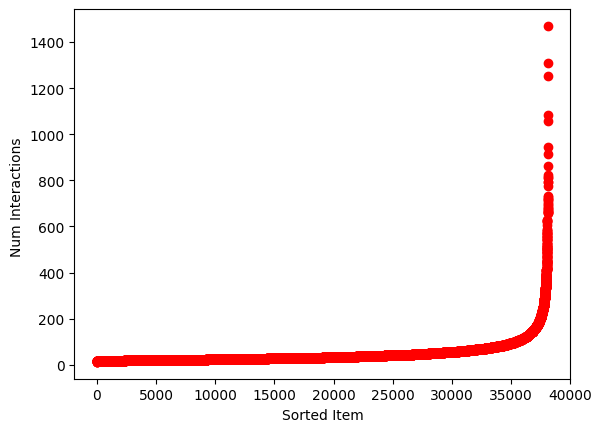

In [20]:
plt.plot(item_popularity, 'ro')
plt.ylabel('Num Interactions ')
plt.xlabel('Sorted Item')
plt.show()

In [21]:
ten_percent = int(n_items/10)

print("Average per-item interactions over the whole dataset {:.2f}".
      format(item_popularity.mean()))

print("Average per-item interactions for the top 10% popular items {:.2f}".
      format(item_popularity[-ten_percent:].mean()))

print("Average per-item interactions for the least 10% popular items {:.2f}".
      format(item_popularity[:ten_percent].mean()))

print("Average per-item interactions for the median 10% popular items {:.2f}".
      format(item_popularity[int(n_items*0.45):int(n_items*0.55)].mean()))

Average per-item interactions over the whole dataset 46.29
Average per-item interactions for the top 10% popular items 153.63
Average per-item interactions for the least 10% popular items 17.95
Average per-item interactions for the median 10% popular items 31.50


In [22]:
print("Number of items with zero interactions {}".
      format(np.sum(item_popularity==0)))

Number of items with zero interactions 0


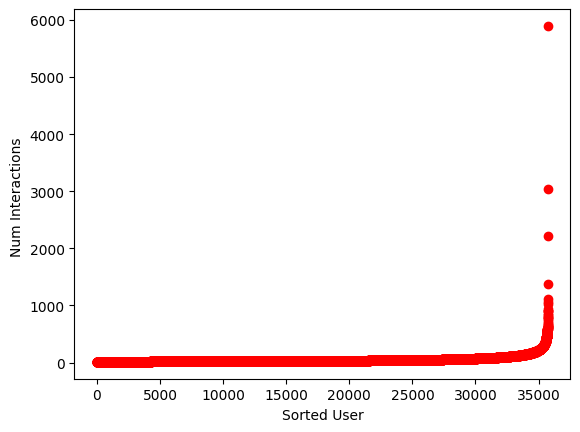

In [23]:
user_activity = np.ediff1d(URM_all.tocsr().indptr)
user_activity = np.sort(user_activity)


plt.plot(user_activity, 'ro')
plt.ylabel('Num Interactions ')
plt.xlabel('Sorted User')
plt.show()

## ICM
The ICM has one item for each row and one feature for each column

In [24]:
ICM_all_dataframe = pd.read_csv("/kaggle/input/recommender-system-2024-challenge-polimi/data_ICM_metadata.csv")
ICM_all_dataframe.head(10)

,item_id,feature_id,data
0,2519,0,1.0
1,2642,0,1.0
2,3316,0,1.0
3,3400,0,1.0
4,3472,0,1.0
5,4361,0,1.0
6,4661,0,1.0
7,8697,0,1.0
8,9692,0,1.0
9,9693,0,1.0


In [25]:
featureID_unique = ICM_all_dataframe["feature_id"].unique()
itemID_unique_ICM = ICM_all_dataframe["item_id"].unique()

In [26]:
n_features = len(featureID_unique)
n_items_ICM = len(itemID_unique_ICM)
n_interactions_ICM = len(ICM_all_dataframe)

print ("Number of items\t {}, Number of features\t {}".format(n_items_ICM, n_features))
print ("Max ID items\t {}, Max Id features\t {}\n".format(max(itemID_unique_ICM), max(featureID_unique)))

Number of items	 38121, Number of features	 94331
Max ID items	 38120, Max Id features	 94330



In [27]:
mapped_id, original_id = pd.factorize(ICM_all_dataframe["feature_id"].unique())
feature_original_ID_to_index = pd.Series(mapped_id, index=original_id)

mapped_id, original_id = pd.factorize(ICM_all_dataframe["item_id"].unique())
item_original_ID_to_index_ICM = pd.Series(mapped_id, index=original_id)

In [28]:
ICM_all_dataframe["feature_id"] = ICM_all_dataframe["feature_id"].map(feature_original_ID_to_index)
ICM_all_dataframe["item_id"] = ICM_all_dataframe["item_id"].map(item_original_ID_to_index_ICM)

In [29]:
ICM_all_dataframe.head(n=10)

,item_id,feature_id,data
0,0,0,1.0
1,1,0,1.0
2,2,0,1.0
3,3,0,1.0
4,4,0,1.0
5,5,0,1.0
6,6,0,1.0
7,7,0,1.0
8,8,0,1.0
9,9,0,1.0


In [30]:
featureID_unique = ICM_all_dataframe["feature_id"].unique()
itemID_unique_ICM = ICM_all_dataframe["item_id"].unique()

n_features = len(featureID_unique)
n_items_ICM = len(itemID_unique_ICM)
n_interactions_ICM = len(ICM_all_dataframe)

print ("Number of items\t {}, Number of features\t {}".format(n_items_ICM, n_features))
print ("Max ID items\t {}, Max Id features\t {}\n".format(max(itemID_unique_ICM), max(featureID_unique)))
print ("Average interactions per feature {:.2f}".format(n_interactions_ICM/n_features))
print ("Average interactions per item {:.2f}\n".format(n_interactions_ICM/n_items_ICM))

print ("Sparsity {:.2f} %".format((1-float(n_interactions_ICM)/(n_items_ICM*n_features))*100))


Number of items	 38121, Number of features	 94331
Max ID items	 38120, Max Id features	 94330

Average interactions per feature 31.17
Average interactions per item 77.12

Sparsity 99.92 %


In [31]:
ICM_all = sps.coo_matrix((ICM_all_dataframe["data"].values, (ICM_all_dataframe["item_id"].values,ICM_all_dataframe["feature_id"].values)))


ICM_all

<COOrdinate sparse matrix of dtype 'float64'
	with 2940040 stored elements and shape (38121, 94331)>

In [32]:
ICM_all.tocsr()

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 2940040 stored elements and shape (38121, 94331)>

In [33]:
item_popularity_ICM = np.ediff1d(ICM_all.tocsr().indptr)       # tocsc(), when rows and columns inverted
item_popularity_ICM = np.sort(item_popularity_ICM)
item_popularity_ICM 

array([   1,    1,    1, ..., 1084, 1199, 2013], dtype=int32)

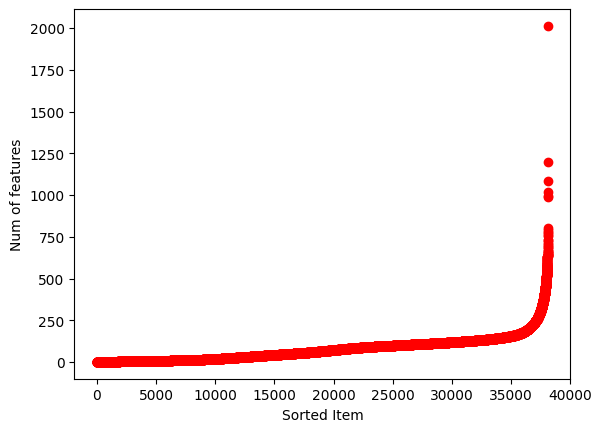

In [34]:
plt.plot(item_popularity_ICM, 'ro')
plt.ylabel('Num of features')
plt.xlabel('Sorted Item')
plt.show()

In [35]:
ten_percent = int(n_items_ICM/10)

print("Average per-item interactions over the whole dataset {:.2f}".
      format(item_popularity_ICM.mean()))

print("Average per-item interactions for the top 10% popular items {:.2f}".
      format(item_popularity_ICM[-ten_percent:].mean()))

print("Average per-item interactions for the least 10% popular items {:.2f}".
      format(item_popularity_ICM[:ten_percent].mean()))

print("Average per-item interactions for the median 10% popular items {:.2f}".
      format(item_popularity_ICM[int(n_items_ICM*0.45):int(n_items_ICM*0.55)].mean()))

Average per-item interactions over the whole dataset 77.12
Average per-item interactions for the top 10% popular items 228.64
Average per-item interactions for the least 10% popular items 3.77
Average per-item interactions for the median 10% popular items 65.90


# Creating a validation set for testing our recommendation models

In [36]:
%cd /kaggle/working/RecSys_Challenge_Polimi_2024

/kaggle/working/RecSys_Challenge_Polimi_2024


/usr/local/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [37]:
from Data_manager.split_functions.split_train_validation_random_holdout import split_train_in_two_percentage_global_sample
from Evaluation.Evaluator import EvaluatorHoldout

In [38]:
URM_train, URM_validation = split_train_in_two_percentage_global_sample(URM_all, train_percentage = 0.80)

evaluator_validation = EvaluatorHoldout(URM_validation, cutoff_list=[10])

EvaluatorHoldout: Ignoring 158 ( 0.4%) Users that have less than 1 test interactions


# 1. CFItemKNN recommender
## Taken from practice 05 file

In [ ]:
def matrix_similarity(urm: sp.csc_matrix, shrink: int):
    item_weights = np.sqrt(
        np.sum(urm.power(2), axis=0)
    ).A
    
    numerator = urm.T.dot(urm)
    denominator = item_weights.T.dot(item_weights) + shrink + 1e-6
    weights = numerator / denominator
    weights = weights.todense()
    np.fill_diagonal(weights, 0.0)
    
    return weights

In [ ]:
urm_csc = URM_train.tocsc()
shrink = 5
slice_size = 100

In [ ]:
%%time
matrix_weights = matrix_similarity(urm_csc[:slice_size,:slice_size], shrink)
matrix_weights

In [ ]:
from typing import Tuple, Callable, Dict, Optional, List

In [ ]:
class CFItemKNN(object):
    def __init__(self, shrink: int):
        self.shrink = shrink
        self.weights = None
    
    
    def fit(self, urm_train: sp.csc_matrix, similarity_function):
        if not sp.isspmatrix_csc(urm_train):
            raise TypeError(f"We expected a CSC matrix, we got {type(urm_train)}")
        
        self.weights = similarity_function(urm_train, self.shrink)
        
    def recommend(self, user_id: int, urm_train: sp.csr_matrix, at: Optional[int] = None, remove_seen: bool = True):
        user_profile = urm_train[user_id]
        
        ranking = user_profile.dot(self.weights).A.flatten()
        
        if remove_seen:
            user_profile_start = urm_train.indptr[user_id]
            user_profile_end = urm_train.indptr[user_id+1]
            
            seen_items = urm_train.indices[user_profile_start:user_profile_end]
            
            ranking[seen_items] = -np.inf
            
        ranking = np.flip(np.argsort(ranking))
        return ranking[:at]

In [ ]:
itemknn_recommender = CFItemKNN(shrink=50)
itemknn_recommender

In [ ]:
%%time

itemknn_recommender.fit(URM_train.tocsc(), matrix_similarity)

In [ ]:
def recall(recommendations: np.array, relevant_items: np.array) -> float:
    is_relevant = np.in1d(recommendations, relevant_items, assume_unique=True)
    
    recall_score = np.sum(is_relevant) / relevant_items.shape[0]
    
    return recall_score
    
    
def precision(recommendations: np.array, relevant_items: np.array) -> float:
    is_relevant = np.in1d(recommendations, relevant_items, assume_unique=True)
    
    precision_score = np.sum(is_relevant) / recommendations.shape[0]

    return precision_score

def mean_average_precision(recommendations: np.array, relevant_items: np.array) -> float:
    is_relevant = np.in1d(recommendations, relevant_items, assume_unique=True)
    
    precision_at_k = is_relevant * np.cumsum(is_relevant, dtype=np.float32) / (1 + np.arange(is_relevant.shape[0]))

    map_score = np.sum(precision_at_k) / np.min([relevant_items.shape[0], is_relevant.shape[0]])

    return map_score
    

In [ ]:
def evaluator(recommender: object, urm_train: sp.csr_matrix, urm_test: sp.csr_matrix):
    recommendation_length = 10
    accum_precision = 0
    accum_recall = 0
    accum_map = 0
    
    num_users = urm_train.shape[0]
    
    num_users_evaluated = 0
    num_users_skipped = 0
    for user_id in range(num_users):
        user_profile_start = urm_test.indptr[user_id]
        user_profile_end = urm_test.indptr[user_id+1]
        
        relevant_items = urm_test.indices[user_profile_start:user_profile_end]
        
        if relevant_items.size == 0:
            num_users_skipped += 1
            continue
            
        recommendations = recommender.recommend(user_id=user_id, 
                                               at=recommendation_length, 
                                               urm_train=urm_train, 
                                               remove_seen=True)
        
        accum_precision += precision(recommendations, relevant_items)
        accum_recall += recall(recommendations, relevant_items)
        accum_map += mean_average_precision(recommendations, relevant_items)
        
        num_users_evaluated += 1
        
    
    accum_precision /= max(num_users_evaluated, 1)
    accum_recall /= max(num_users_evaluated, 1)
    accum_map /=  max(num_users_evaluated, 1)
    
    return accum_precision, accum_recall, accum_map, num_users_evaluated, num_users_skipped
    

In [ ]:
%%time

accum_precision, accum_recall, accum_map, num_user_evaluated, num_users_skipped = evaluator(itemknn_recommender, 
                                                                                            URM_train, 
                                                                                            URM_validation)

In [ ]:
accum_precision, accum_recall, accum_map, num_user_evaluated, num_users_skipped

# Submission code

In [ ]:
target_users_df = pd.read_csv('/kaggle/input/recommender-system-2024-challenge-polimi/data_target_users_test.csv')
users_to_recommend = np.array(target_users_df)
users_to_recommend = np.squeeze(users_to_recommend)
users_to_recommend.shape

In [ ]:
def preprocess_data(ratings: pd.DataFrame):
    unique_users = ratings.user_id.unique()
    unique_items = ratings.item_id.unique()
    
    num_users, min_user_id, max_user_id = unique_users.size, unique_users.min(), unique_users.max()
    num_items, min_item_id, max_item_id = unique_items.size, unique_items.min(), unique_items.max()
    
    print(num_users, min_user_id, max_user_id)
    print(num_items, min_item_id, max_item_id)
    
    mapping_user_id = pd.DataFrame({"mapped_user_id": np.arange(num_users), "user_id": unique_users})
    mapping_item_id = pd.DataFrame({"mapped_item_id": np.arange(num_items), "item_id": unique_items})
    
    ratings = pd.merge(left=ratings, 
                       right=mapping_user_id,
                       how="inner",
                       on="user_id")
    
    ratings = pd.merge(left=ratings, 
                       right=mapping_item_id,
                       how="inner",
                       on="item_id")
    
    return ratings
    

In [ ]:
ratings = pd.read_csv('/kaggle/input/recommender-system-2024-challenge-polimi/data_train.csv')
ratings = preprocess_data(ratings)

In [ ]:
def dataset_splits(ratings, num_users, num_items, validation_percentage: float, testing_percentage: float):
    seed = 1234
    
    (user_ids_training, user_ids_test,
     item_ids_training, item_ids_test,
     ratings_training, ratings_test) = train_test_split(ratings.mapped_user_id,
                                                        ratings.mapped_item_id,
                                                        ratings.ratings,
                                                        test_size=testing_percentage,
                                                        shuffle=True,
                                                        random_state=seed)
    
    (user_ids_training, user_ids_validation,
     item_ids_training, item_ids_validation,
     ratings_training, ratings_validation) = train_test_split(user_ids_training,
                                                              item_ids_training,
                                                              ratings_training,
                                                              test_size=validation_percentage,
                                                             )
    
    urm_train = sp.csr_matrix((ratings_training, (user_ids_training, item_ids_training)), 
                              shape=(num_users, num_items))
    
    urm_validation = sp.csr_matrix((ratings_validation, (user_ids_validation, item_ids_validation)), 
                              shape=(num_users, num_items))
    
    urm_test = sp.csr_matrix((ratings_test, (user_ids_test, item_ids_test)), 
                              shape=(num_users, num_items))
    
    
    
    return urm_train, urm_validation, urm_test
    
    
    
    

In [ ]:
def prepare_submission(ratings: pd.DataFrame, users_to_recommend: np.array, urm_train: sp.csr_matrix, recommender: object):
    users_ids_and_mappings = ratings[ratings.user_id.isin(users_to_recommend)][["user_id", "mapped_user_id"]].drop_duplicates()
    items_ids_and_mappings = ratings[["item_id", "mapped_item_id"]].drop_duplicates()
    
    mapping_to_item_id = dict(zip(ratings.mapped_item_id, ratings.item_id))
    
    
    recommendation_length = 10
    submission = []
    for idx, row in users_ids_and_mappings.iterrows():
        user_id = row.user_id
        mapped_user_id = row.mapped_user_id
        
        recommendations = recommender.recommend(user_id=mapped_user_id,
                                                urm_train=urm_train,
                                                at=recommendation_length,
                                                remove_seen=True)
        
        submission.append((user_id, [mapping_to_item_id[item_id] for item_id in recommendations]))
        
    return submission
    

In [ ]:
urm_train_validation = URM_train + URM_validation

In [ ]:
submission = prepare_submission(ratings, users_to_recommend, urm_train_validation, itemknn_recommender)

In [ ]:
submission

In [ ]:
def write_submission(submissions):
    with open("/kaggle/working/submission.csv", "w") as f:
        f.write("user_id,item_list\n")
        for user_id, items in submissions:
            f.write(f"{user_id},{' '.join([str(item) for item in items])}\n")
    

In [ ]:
write_submission(submission)

# Test

In [39]:
!python3 run_compile_all_cython.py build_ext --inplace

run_compile_all_cython: Found 11 Cython files in 5 folders...
run_compile_all_cython: All files will be compiled using your current python environment: '/usr/local/bin/python3'
Compiling [1/11]: MatrixFactorization_Cython_Epoch.pyx... 
Traceback (most recent call last):
  File "/kaggle/working/RecSys_Challenge_Polimi_2024/CythonCompiler/compile_script.py", line 24, in <module>
    from Cython.Distutils import build_ext
ModuleNotFoundError: No module named 'Cython'
Traceback (most recent call last):
  File "/kaggle/working/RecSys_Challenge_Polimi_2024/run_compile_all_cython.py", line 60, in <module>
    run_compile_subprocess(file_path, [file_name])
  File "/kaggle/working/RecSys_Challenge_Polimi_2024/CythonCompiler/run_compile_subprocess.py", line 51, in run_compile_subprocess
    raise exc
  File "/kaggle/working/RecSys_Challenge_Polimi_2024/CythonCompiler/run_compile_subprocess.py", line 32, in run_compile_subprocess
    output = subprocess.check_output(' '.join(command),
  File "/us

In [40]:
from tqdm import tqdm

In [41]:
from Recommenders.Recommender_import_list import *

from Data_manager.Movielens.Movielens1MReader import Movielens1MReader
from Data_manager.DataSplitter_leave_k_out import DataSplitter_leave_k_out
from Recommenders.Incremental_Training_Early_Stopping import Incremental_Training_Early_Stopping
from Recommenders.BaseCBFRecommender import BaseItemCBFRecommender, BaseUserCBFRecommender
from Evaluation.Evaluator import EvaluatorHoldout
import traceback, os


def _get_instance(recommender_class, URM_train, ICM_all, UCM_all=None):

    if issubclass(recommender_class, BaseItemCBFRecommender):
        recommender_object = recommender_class(URM_train, ICM_all)
    #elif issubclass(recommender_class, BaseUserCBFRecommender):
        #recommender_object = recommender_class(URM_train, UCM_all)
    else:
        recommender_object = recommender_class(URM_train)

    return recommender_object

recommender_class_list = [
        Random,
        TopPop,
        GlobalEffects,
        SLIMElasticNetRecommender,
        UserKNNCFRecommender,
        IALSRecommender,
        MatrixFactorization_BPR_Cython,
        #MatrixFactorization_FunkSVD_Cython,
        MatrixFactorization_AsySVD_Cython,
        EASE_R_Recommender,
        ItemKNNCFRecommender,
        P3alphaRecommender,
        SLIM_BPR_Cython,
        RP3betaRecommender,
        PureSVDRecommender,
        NMFRecommender,
        UserKNNCBFRecommender,
        ItemKNNCBFRecommender,
        UserKNN_CFCBF_Hybrid_Recommender,
        ItemKNN_CFCBF_Hybrid_Recommender,
        LightFMCFRecommender,
        LightFMUserHybridRecommender,
        LightFMItemHybridRecommender,
        ]


evaluator = EvaluatorHoldout(URM_validation, [5, 20], exclude_seen=True)   # URM_test

# from MatrixFactorization.PyTorch.MF_MSE_PyTorch import MF_MSE_PyTorch

earlystopping_keywargs = {"validation_every_n": 5,
                          "stop_on_validation": True,
                          "evaluator_object": EvaluatorHoldout(URM_validation, [20], exclude_seen=True),
                          "lower_validations_allowed": 5,
                          "validation_metric": "MAP",
                          }


output_root_path = "./result_experiments/"

# If directory does not exist, create
if not os.path.exists(output_root_path):
    os.makedirs(output_root_path)


logFile = open(output_root_path + "result_all_algorithms.txt", "a")


for recommender_class in tqdm(recommender_class_list):

    try:

        print("Algorithm: {}".format(recommender_class))

        recommender_object = _get_instance(recommender_class, URM_train, ICM_all)#, UCM_all)

        if isinstance(recommender_object, Incremental_Training_Early_Stopping):
            fit_params = {"epochs": 15, **earlystopping_keywargs}
        else:
            fit_params = {}

        recommender_object.fit(**fit_params)

        results_run_1, results_run_string_1 = evaluator.evaluateRecommender(recommender_object)

        recommender_object.save_model(output_root_path, file_name = "temp_model.zip")

        recommender_object = _get_instance(recommender_class, URM_train, ICM_all) #, UCM_all)
        recommender_object.load_model(output_root_path, file_name = "temp_model.zip")

        os.remove(output_root_path + "temp_model.zip")

        results_run_2, results_run_string_2 = evaluator.evaluateRecommender(recommender_object)

        if recommender_class not in [Random]:
            assert results_run_1.equals(results_run_2)

        print("Algorithm: {}, results: \n{}".format(recommender_class, results_run_string_1))
        logFile.write("Algorithm: {}, results: \n{}\n".format(recommender_class, results_run_string_1))
        logFile.flush()


    except Exception as e:
        traceback.print_exc()
        logFile.write("Algorithm: {} - Exception: {}\n".format(recommender_class, str(e)))
        logFile.flush()

E0000 00:00:1732731228.856559      13 common_lib.cc:798] Could not set metric server port: INVALID_ARGUMENT: Could not find SliceBuilder port 8471 in any of the 0 ports provided in `tpu_process_addresses`="local"
=== Source Location Trace: === 
learning/45eac/tfrc/runtime/common_lib.cc:479
D1127 18:13:48.864077105      13 config.cc:196]                        gRPC EXPERIMENT call_status_override_on_cancellation   OFF (default:OFF)
D1127 18:13:48.864090979      13 config.cc:196]                        gRPC EXPERIMENT call_v3                                OFF (default:OFF)
D1127 18:13:48.864094276      13 config.cc:196]                        gRPC EXPERIMENT canary_client_privacy                  ON  (default:ON)
D1127 18:13:48.864096708      13 config.cc:196]                        gRPC EXPERIMENT capture_base_context                   ON  (default:ON)
D1127 18:13:48.864099212      13 config.cc:196]                        gRPC EXPERIMENT client_idleness                        ON  (defa

EvaluatorHoldout: Ignoring 158 ( 0.4%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 158 ( 0.4%) Users that have less than 1 test interactions
Algorithm: <class 'Recommenders.NonPersonalizedRecommender.Random'>
EvaluatorHoldout: Processed 35578 (100.0%) in 50.35 sec. Users per second: 707
RandomRecommender: Saving model in file './result_experiments/temp_model.zip'
RandomRecommender: Saving complete
RandomRecommender: Loading model from file './result_experiments/temp_model.zip'
RandomRecommender: Loading complete
EvaluatorHoldout: Processed 35578 (100.0%) in 50.29 sec. Users per second: 707


  5%|▍         | 1/22 [01:40<35:15, 100.74s/it]

Algorithm: <class 'Recommenders.NonPersonalizedRecommender.Random'>, results: 
CUTOFF: 5 - PRECISION: 0.0003148, PRECISION_RECALL_MIN_DEN: 0.0003251, RECALL: 0.0001320, MAP: 0.0001302, MAP_MIN_DEN: 0.0001344, MRR: 0.0006371, NDCG: 0.0003012, F1: 0.0001860, HIT_RATE: 0.0015459, ARHR_ALL_HITS: 0.0006441, NOVELTY: 0.0020429, AVERAGE_POPULARITY: 0.0319462, DIVERSITY_MEAN_INTER_LIST: 0.9998691, DIVERSITY_HERFINDAHL: 0.9999682, COVERAGE_ITEM: 0.9906613, COVERAGE_ITEM_HIT: 0.0014690, ITEMS_IN_GT: 0.9958815, COVERAGE_USER: 0.9955787, COVERAGE_USER_HIT: 0.0015391, USERS_IN_GT: 0.9955787, DIVERSITY_GINI: 0.7436703, SHANNON_ENTROPY: 15.0571280, RATIO_DIVERSITY_HERFINDAHL: 1.0000259, RATIO_DIVERSITY_GINI: 1.2223245, RATIO_SHANNON_ENTROPY: 1.0199726, RATIO_AVERAGE_POPULARITY: 0.4266568, RATIO_NOVELTY: 0.1335472, 
CUTOFF: 20 - PRECISION: 0.0002586, PRECISION_RECALL_MIN_DEN: 0.0005525, RECALL: 0.0005059, MAP: 0.0000488, MAP_MIN_DEN: 0.0000957, MRR: 0.0009575, NDCG: 0.0003961, F1: 0.0003422, HIT_RATE:

  9%|▉         | 2/22 [02:50<27:27, 82.38s/it] 

Algorithm: <class 'Recommenders.NonPersonalizedRecommender.TopPop'>, results: 
CUTOFF: 5 - PRECISION: 0.0078925, PRECISION_RECALL_MIN_DEN: 0.0085385, RECALL: 0.0047761, MAP: 0.0039314, MAP_MIN_DEN: 0.0042382, MRR: 0.0185714, NDCG: 0.0085391, F1: 0.0059510, HIT_RATE: 0.0373264, ARHR_ALL_HITS: 0.0190951, NOVELTY: 0.0013791, AVERAGE_POPULARITY: 0.8397943, DIVERSITY_MEAN_INTER_LIST: 0.0516738, DIVERSITY_HERFINDAHL: 0.8103345, COVERAGE_ITEM: 0.0003148, COVERAGE_ITEM_HIT: 0.0002623, ITEMS_IN_GT: 0.9958815, COVERAGE_USER: 0.9955787, COVERAGE_USER_HIT: 0.0371614, USERS_IN_GT: 0.9955787, DIVERSITY_GINI: 0.0001619, SHANNON_ENTROPY: 2.4664454, RATIO_DIVERSITY_HERFINDAHL: 0.8103813, RATIO_DIVERSITY_GINI: 0.0002661, RATIO_SHANNON_ENTROPY: 0.1670775, RATIO_AVERAGE_POPULARITY: 11.2158600, RATIO_NOVELTY: 0.0901487, 
CUTOFF: 20 - PRECISION: 0.0055512, PRECISION_RECALL_MIN_DEN: 0.0135688, RECALL: 0.0129476, MAP: 0.0014090, MAP_MIN_DEN: 0.0033948, MRR: 0.0235265, NDCG: 0.0104275, F1: 0.0077707, HIT_RATE:

 14%|█▎        | 3/22 [03:49<22:42, 71.73s/it]

Algorithm: <class 'Recommenders.NonPersonalizedRecommender.GlobalEffects'>, results: 
CUTOFF: 5 - PRECISION: 0.0003317, PRECISION_RECALL_MIN_DEN: 0.0003354, RECALL: 0.0001565, MAP: 0.0001703, MAP_MIN_DEN: 0.0001722, MRR: 0.0008329, NDCG: 0.0003550, F1: 0.0002126, HIT_RATE: 0.0016302, ARHR_ALL_HITS: 0.0008423, NOVELTY: 0.0020592, AVERAGE_POPULARITY: 0.0264563, DIVERSITY_MEAN_INTER_LIST: 0.8044550, DIVERSITY_HERFINDAHL: 0.9608865, COVERAGE_ITEM: 0.0066368, COVERAGE_ITEM_HIT: 0.0007607, ITEMS_IN_GT: 0.9958815, COVERAGE_USER: 0.9955787, COVERAGE_USER_HIT: 0.0016230, USERS_IN_GT: 0.9955787, DIVERSITY_GINI: 0.0007334, SHANNON_ENTROPY: 5.1744509, RATIO_DIVERSITY_HERFINDAHL: 0.9609420, RATIO_DIVERSITY_GINI: 0.0012055, RATIO_SHANNON_ENTROPY: 0.3505182, RATIO_AVERAGE_POPULARITY: 0.3533362, RATIO_NOVELTY: 0.1346095, 
CUTOFF: 20 - PRECISION: 0.0002853, PRECISION_RECALL_MIN_DEN: 0.0006382, RECALL: 0.0006134, MAP: 0.0000618, MAP_MIN_DEN: 0.0001385, MRR: 0.0011920, NDCG: 0.0004938, F1: 0.0003894, HIT

 18%|█▊        | 4/22 [11:27<1:07:20, 224.45s/it]

Algorithm: <class 'Recommenders.SLIM.SLIMElasticNetRecommender.SLIMElasticNetRecommender'>, results: 
CUTOFF: 5 - PRECISION: 0.0003317, PRECISION_RECALL_MIN_DEN: 0.0003354, RECALL: 0.0001565, MAP: 0.0001703, MAP_MIN_DEN: 0.0001722, MRR: 0.0008329, NDCG: 0.0003550, F1: 0.0002126, HIT_RATE: 0.0016302, ARHR_ALL_HITS: 0.0008423, NOVELTY: 0.0020592, AVERAGE_POPULARITY: 0.0264563, DIVERSITY_MEAN_INTER_LIST: 0.8044550, DIVERSITY_HERFINDAHL: 0.9608865, COVERAGE_ITEM: 0.0066368, COVERAGE_ITEM_HIT: 0.0007607, ITEMS_IN_GT: 0.9958815, COVERAGE_USER: 0.9955787, COVERAGE_USER_HIT: 0.0016230, USERS_IN_GT: 0.9955787, DIVERSITY_GINI: 0.0007334, SHANNON_ENTROPY: 5.1744509, RATIO_DIVERSITY_HERFINDAHL: 0.9609420, RATIO_DIVERSITY_GINI: 0.0012055, RATIO_SHANNON_ENTROPY: 0.3505182, RATIO_AVERAGE_POPULARITY: 0.3533362, RATIO_NOVELTY: 0.1346095, 
CUTOFF: 20 - PRECISION: 0.0002853, PRECISION_RECALL_MIN_DEN: 0.0006382, RECALL: 0.0006134, MAP: 0.0000618, MAP_MIN_DEN: 0.0001385, MRR: 0.0011920, NDCG: 0.0004938, F1

 23%|██▎       | 5/22 [13:31<53:17, 188.11s/it]  

Algorithm: <class 'Recommenders.KNN.UserKNNCFRecommender.UserKNNCFRecommender'>, results: 
CUTOFF: 5 - PRECISION: 0.0791332, PRECISION_RECALL_MIN_DEN: 0.0863118, RECALL: 0.0499230, MAP: 0.0507709, MAP_MIN_DEN: 0.0551535, MRR: 0.1773849, NDCG: 0.0917541, F1: 0.0612224, HIT_RATE: 0.2856541, ARHR_ALL_HITS: 0.2116537, NOVELTY: 0.0018561, AVERAGE_POPULARITY: 0.1126222, DIVERSITY_MEAN_INTER_LIST: 0.9988804, DIVERSITY_HERFINDAHL: 0.9997705, COVERAGE_ITEM: 0.7240629, COVERAGE_ITEM_HIT: 0.1558196, ITEMS_IN_GT: 0.9958815, COVERAGE_USER: 0.9955787, COVERAGE_USER_HIT: 0.2843911, USERS_IN_GT: 0.9955787, DIVERSITY_GINI: 0.2708767, SHANNON_ENTROPY: 13.5074310, RATIO_DIVERSITY_HERFINDAHL: 0.9998282, RATIO_DIVERSITY_GINI: 0.4452231, RATIO_SHANNON_ENTROPY: 0.9149958, RATIO_AVERAGE_POPULARITY: 1.5041234, RATIO_NOVELTY: 0.1213316, 
CUTOFF: 20 - PRECISION: 0.0452176, PRECISION_RECALL_MIN_DEN: 0.1082002, RECALL: 0.1029186, MAP: 0.0184345, MAP_MIN_DEN: 0.0436676, MRR: 0.1948957, NDCG: 0.0960289, F1: 0.062830

 27%|██▋       | 6/22 [19:10<1:03:48, 239.28s/it]

Algorithm: <class 'Recommenders.MatrixFactorization.IALSRecommender.IALSRecommender'>, results: 
CUTOFF: 5 - PRECISION: 0.0350779, PRECISION_RECALL_MIN_DEN: 0.0377668, RECALL: 0.0206561, MAP: 0.0202539, MAP_MIN_DEN: 0.0217217, MRR: 0.0815326, NDCG: 0.0394371, F1: 0.0260011, HIT_RATE: 0.1452864, ARHR_ALL_HITS: 0.0905808, NOVELTY: 0.0015522, AVERAGE_POPULARITY: 0.4025881, DIVERSITY_MEAN_INTER_LIST: 0.9414595, DIVERSITY_HERFINDAHL: 0.9882866, COVERAGE_ITEM: 0.0140867, COVERAGE_ITEM_HIT: 0.0092600, ITEMS_IN_GT: 0.9958815, COVERAGE_USER: 0.9955787, COVERAGE_USER_HIT: 0.1446441, USERS_IN_GT: 0.9955787, DIVERSITY_GINI: 0.0029929, SHANNON_ENTROPY: 7.1960740, RATIO_DIVERSITY_HERFINDAHL: 0.9883437, RATIO_DIVERSITY_GINI: 0.0049192, RATIO_SHANNON_ENTROPY: 0.4874634, RATIO_AVERAGE_POPULARITY: 5.3767583, RATIO_NOVELTY: 0.1014673, 
CUTOFF: 20 - PRECISION: 0.0246276, PRECISION_RECALL_MIN_DEN: 0.0592507, RECALL: 0.0562184, MAP: 0.0076946, MAP_MIN_DEN: 0.0176822, MRR: 0.0979813, NDCG: 0.0471621, F1: 0.0

Traceback (most recent call last):
  File "/tmp/ipykernel_13/898331646.py", line 84, in <module>
    recommender_object.fit(**fit_params)
  File "/kaggle/working/RecSys_Challenge_Polimi_2024/Recommenders/MatrixFactorization/Cython/MatrixFactorization_Cython.py", line 169, in fit
    super(MatrixFactorization_BPR_Cython, self).fit(**key_args)
  File "/kaggle/working/RecSys_Challenge_Polimi_2024/Recommenders/MatrixFactorization/Cython/MatrixFactorization_Cython.py", line 57, in fit
    from Recommenders.MatrixFactorization.Cython.MatrixFactorization_Cython_Epoch import MatrixFactorization_Cython_Epoch
ModuleNotFoundError: No module named 'Recommenders.MatrixFactorization.Cython.MatrixFactorization_Cython_Epoch'
Traceback (most recent call last):
  File "/tmp/ipykernel_13/898331646.py", line 84, in <module>
    recommender_object.fit(**fit_params)
  File "/kaggle/working/RecSys_Challenge_Polimi_2024/Recommenders/MatrixFactorization/Cython/MatrixFactorization_Cython.py", line 249, in fit
 

EASE_R_Recommender: Fitting model... done in 3.35 min
EvaluatorHoldout: Processed 35578 (100.0%) in 1.20 min. Users per second: 496
EASE_R_Recommender: Saving model in file './result_experiments/temp_model.zip'
EASE_R_Recommender: Saving complete
EASE_R_Recommender: Loading model from file './result_experiments/temp_model.zip'
EASE_R_Recommender: Loading complete
EvaluatorHoldout: Processed 35578 (100.0%) in 1.19 min. Users per second: 497


 41%|████      | 9/22 [30:31<50:17, 232.11s/it]  

Algorithm: <class 'Recommenders.EASE_R.EASE_R_Recommender.EASE_R_Recommender'>, results: 
CUTOFF: 5 - PRECISION: 0.1024791, PRECISION_RECALL_MIN_DEN: 0.1126797, RECALL: 0.0690755, MAP: 0.0646671, MAP_MIN_DEN: 0.0707060, MRR: 0.2233454, NDCG: 0.1177132, F1: 0.0825252, HIT_RATE: 0.3675586, ARHR_ALL_HITS: 0.2681292, NOVELTY: 0.0016871, AVERAGE_POPULARITY: 0.2400325, DIVERSITY_MEAN_INTER_LIST: 0.9899227, DIVERSITY_HERFINDAHL: 0.9979790, COVERAGE_ITEM: 0.2295847, COVERAGE_ITEM_HIT: 0.1104903, ITEMS_IN_GT: 0.9958815, COVERAGE_USER: 0.9955787, COVERAGE_USER_HIT: 0.3659335, USERS_IN_GT: 0.9955787, DIVERSITY_GINI: 0.0444472, SHANNON_ENTROPY: 10.6770020, RATIO_DIVERSITY_HERFINDAHL: 0.9980366, RATIO_DIVERSITY_GINI: 0.0730551, RATIO_SHANNON_ENTROPY: 0.7232620, RATIO_AVERAGE_POPULARITY: 3.2057497, RATIO_NOVELTY: 0.1102825, 
CUTOFF: 20 - PRECISION: 0.0615802, PRECISION_RECALL_MIN_DEN: 0.1599919, RECALL: 0.1543365, MAP: 0.0241194, MAP_MIN_DEN: 0.0606363, MRR: 0.2474648, NDCG: 0.1330840, F1: 0.0880346

 45%|████▌     | 10/22 [32:44<42:02, 210.17s/it]

Algorithm: <class 'Recommenders.KNN.ItemKNNCFRecommender.ItemKNNCFRecommender'>, results: 
CUTOFF: 5 - PRECISION: 0.1092136, PRECISION_RECALL_MIN_DEN: 0.1197182, RECALL: 0.0726077, MAP: 0.0708509, MAP_MIN_DEN: 0.0774011, MRR: 0.2385201, NDCG: 0.1265406, F1: 0.0872257, HIT_RATE: 0.3813593, ARHR_ALL_HITS: 0.2900496, NOVELTY: 0.0017765, AVERAGE_POPULARITY: 0.1580476, DIVERSITY_MEAN_INTER_LIST: 0.9967281, DIVERSITY_HERFINDAHL: 0.9993400, COVERAGE_ITEM: 0.3729178, COVERAGE_ITEM_HIT: 0.1534063, ITEMS_IN_GT: 0.9958815, COVERAGE_USER: 0.9955787, COVERAGE_USER_HIT: 0.3796732, USERS_IN_GT: 0.9955787, DIVERSITY_GINI: 0.0978419, SHANNON_ENTROPY: 11.9870949, RATIO_DIVERSITY_HERFINDAHL: 0.9993977, RATIO_DIVERSITY_GINI: 0.1608167, RATIO_SHANNON_ENTROPY: 0.8120080, RATIO_AVERAGE_POPULARITY: 2.1108026, RATIO_NOVELTY: 0.1161290, 
CUTOFF: 20 - PRECISION: 0.0636222, PRECISION_RECALL_MIN_DEN: 0.1631811, RECALL: 0.1569769, MAP: 0.0263131, MAP_MIN_DEN: 0.0651777, MRR: 0.2611702, NDCG: 0.1391403, F1: 0.090546

 50%|█████     | 11/22 [34:29<33:56, 185.16s/it]

Algorithm: <class 'Recommenders.GraphBased.P3alphaRecommender.P3alphaRecommender'>, results: 
CUTOFF: 5 - PRECISION: 0.1123447, PRECISION_RECALL_MIN_DEN: 0.1238415, RECALL: 0.0764707, MAP: 0.0726111, MAP_MIN_DEN: 0.0795057, MRR: 0.2435972, NDCG: 0.1300751, F1: 0.0909998, HIT_RATE: 0.3895666, ARHR_ALL_HITS: 0.2970183, NOVELTY: 0.0018520, AVERAGE_POPULARITY: 0.1112982, DIVERSITY_MEAN_INTER_LIST: 0.9982317, DIVERSITY_HERFINDAHL: 0.9996407, COVERAGE_ITEM: 0.4589596, COVERAGE_ITEM_HIT: 0.1802943, ITEMS_IN_GT: 0.9958815, COVERAGE_USER: 0.9955787, COVERAGE_USER_HIT: 0.3878442, USERS_IN_GT: 0.9955787, DIVERSITY_GINI: 0.1529100, SHANNON_ENTROPY: 12.7404413, RATIO_DIVERSITY_HERFINDAHL: 0.9996985, RATIO_DIVERSITY_GINI: 0.2513287, RATIO_SHANNON_ENTROPY: 0.8630398, RATIO_AVERAGE_POPULARITY: 1.4864415, RATIO_NOVELTY: 0.1210672, 
CUTOFF: 20 - PRECISION: 0.0653817, PRECISION_RECALL_MIN_DEN: 0.1690573, RECALL: 0.1630189, MAP: 0.0271529, MAP_MIN_DEN: 0.0680702, MRR: 0.2661883, NDCG: 0.1438635, F1: 0.093

Traceback (most recent call last):
  File "/tmp/ipykernel_13/898331646.py", line 84, in <module>
    recommender_object.fit(**fit_params)
  File "/kaggle/working/RecSys_Challenge_Polimi_2024/Recommenders/SLIM/Cython/SLIM_BPR_Cython.py", line 76, in fit
    from Recommenders.SLIM.Cython.SLIM_BPR_Cython_Epoch import SLIM_BPR_Cython_Epoch
ModuleNotFoundError: No module named 'Recommenders.SLIM.Cython.SLIM_BPR_Cython_Epoch'


RP3betaRecommender: Similarity column 38121 (100.0%), 1981.64 column/sec. Elapsed time 19.24 sec
EvaluatorHoldout: Processed 35578 (100.0%) in 43.02 sec. Users per second: 827
RP3betaRecommender: Saving model in file './result_experiments/temp_model.zip'
RP3betaRecommender: Saving complete
RP3betaRecommender: Loading model from file './result_experiments/temp_model.zip'
RP3betaRecommender: Loading complete
EvaluatorHoldout: Processed 35578 (100.0%) in 43.03 sec. Users per second: 827


 59%|█████▉    | 13/22 [36:23<19:56, 132.94s/it]

Algorithm: <class 'Recommenders.GraphBased.RP3betaRecommender.RP3betaRecommender'>, results: 
CUTOFF: 5 - PRECISION: 0.1083703, PRECISION_RECALL_MIN_DEN: 0.1195645, RECALL: 0.0742617, MAP: 0.0688378, MAP_MIN_DEN: 0.0755980, MRR: 0.2326564, NDCG: 0.1245586, F1: 0.0881309, HIT_RATE: 0.3799258, ARHR_ALL_HITS: 0.2826377, NOVELTY: 0.0019448, AVERAGE_POPULARITY: 0.0815096, DIVERSITY_MEAN_INTER_LIST: 0.9988775, DIVERSITY_HERFINDAHL: 0.9997699, COVERAGE_ITEM: 0.5953936, COVERAGE_ITEM_HIT: 0.2044805, ITEMS_IN_GT: 0.9958815, COVERAGE_USER: 0.9955787, COVERAGE_USER_HIT: 0.3782460, USERS_IN_GT: 0.9955787, DIVERSITY_GINI: 0.2294104, SHANNON_ENTROPY: 13.3430042, RATIO_DIVERSITY_HERFINDAHL: 0.9998276, RATIO_DIVERSITY_GINI: 0.3770675, RATIO_SHANNON_ENTROPY: 0.9038575, RATIO_AVERAGE_POPULARITY: 1.0885999, RATIO_NOVELTY: 0.1271293, 
CUTOFF: 20 - PRECISION: 0.0641899, PRECISION_RECALL_MIN_DEN: 0.1680102, RECALL: 0.1623538, MAP: 0.0259802, MAP_MIN_DEN: 0.0658771, MRR: 0.2555337, NDCG: 0.1404269, F1: 0.092

 64%|██████▎   | 14/22 [37:54<16:28, 123.52s/it]

Algorithm: <class 'Recommenders.MatrixFactorization.PureSVDRecommender.PureSVDRecommender'>, results: 
CUTOFF: 5 - PRECISION: 0.0556917, PRECISION_RECALL_MIN_DEN: 0.0600034, RECALL: 0.0331294, MAP: 0.0336261, MAP_MIN_DEN: 0.0360713, MRR: 0.1272078, NDCG: 0.0632104, F1: 0.0415449, HIT_RATE: 0.2183934, ARHR_ALL_HITS: 0.1458017, NOVELTY: 0.0016207, AVERAGE_POPULARITY: 0.2737204, DIVERSITY_MEAN_INTER_LIST: 0.9832203, DIVERSITY_HERFINDAHL: 0.9966385, COVERAGE_ITEM: 0.0435193, COVERAGE_ITEM_HIT: 0.0279636, ITEMS_IN_GT: 0.9958815, COVERAGE_USER: 0.9955787, COVERAGE_USER_HIT: 0.2174278, USERS_IN_GT: 0.9955787, DIVERSITY_GINI: 0.0091847, SHANNON_ENTROPY: 8.8579187, RATIO_DIVERSITY_HERFINDAHL: 0.9966961, RATIO_DIVERSITY_GINI: 0.0150963, RATIO_SHANNON_ENTROPY: 0.6000370, RATIO_AVERAGE_POPULARITY: 3.6556681, RATIO_NOVELTY: 0.1059447, 
CUTOFF: 20 - PRECISION: 0.0358564, PRECISION_RECALL_MIN_DEN: 0.0864065, RECALL: 0.0820207, MAP: 0.0125709, MAP_MIN_DEN: 0.0286902, MRR: 0.1461589, NDCG: 0.0712227, F

Traceback (most recent call last):
  File "/tmp/ipykernel_13/898331646.py", line 84, in <module>
    recommender_object.fit(**fit_params)
  File "/kaggle/working/RecSys_Challenge_Polimi_2024/Recommenders/MatrixFactorization/NMFRecommender.py", line 44, in fit
    solver, beta_loss = solver_beta_loss.split(":")
AttributeError: 'NoneType' object has no attribute 'split'
Traceback (most recent call last):
  File "/tmp/ipykernel_13/898331646.py", line 77, in <module>
    recommender_object = _get_instance(recommender_class, URM_train, ICM_all)#, UCM_all)
  File "/tmp/ipykernel_13/898331646.py", line 18, in _get_instance
    recommender_object = recommender_class(URM_train)
TypeError: UserKNNCBFRecommender.__init__() missing 1 required positional argument: 'UCM_train'


Similarity column 38121 (100.0%), 469.94 column/sec. Elapsed time 1.35 min
EvaluatorHoldout: Processed 35578 (100.0%) in 40.69 sec. Users per second: 874
ItemKNNCBFRecommender: Saving model in file './result_experiments/temp_model.zip'
ItemKNNCBFRecommender: Saving complete
ItemKNNCBFRecommender: Loading model from file './result_experiments/temp_model.zip'
ItemKNNCBFRecommender: Loading complete
EvaluatorHoldout: Processed 35578 (100.0%) in 40.76 sec. Users per second: 873


 77%|███████▋  | 17/22 [40:38<07:29, 89.84s/it] 

Algorithm: <class 'Recommenders.KNN.ItemKNNCBFRecommender.ItemKNNCBFRecommender'>, results: 
CUTOFF: 5 - PRECISION: 0.0020462, PRECISION_RECALL_MIN_DEN: 0.0021839, RECALL: 0.0009686, MAP: 0.0011331, MAP_MIN_DEN: 0.0011955, MRR: 0.0047398, NDCG: 0.0022417, F1: 0.0013148, HIT_RATE: 0.0090786, ARHR_ALL_HITS: 0.0051329, NOVELTY: 0.0020368, AVERAGE_POPULARITY: 0.0336822, DIVERSITY_MEAN_INTER_LIST: 0.9984176, DIVERSITY_HERFINDAHL: 0.9996779, COVERAGE_ITEM: 0.4660686, COVERAGE_ITEM_HIT: 0.0076861, ITEMS_IN_GT: 0.9958815, COVERAGE_USER: 0.9955787, COVERAGE_USER_HIT: 0.0090385, USERS_IN_GT: 0.9955787, DIVERSITY_GINI: 0.1472109, SHANNON_ENTROPY: 12.6932564, RATIO_DIVERSITY_HERFINDAHL: 0.9997356, RATIO_DIVERSITY_GINI: 0.2419614, RATIO_SHANNON_ENTROPY: 0.8598435, RATIO_AVERAGE_POPULARITY: 0.4498423, RATIO_NOVELTY: 0.1331461, 
CUTOFF: 20 - PRECISION: 0.0013379, PRECISION_RECALL_MIN_DEN: 0.0027446, RECALL: 0.0024601, MAP: 0.0003892, MAP_MIN_DEN: 0.0007497, MRR: 0.0060044, NDCG: 0.0023294, F1: 0.0017

Traceback (most recent call last):
  File "/tmp/ipykernel_13/898331646.py", line 77, in <module>
    recommender_object = _get_instance(recommender_class, URM_train, ICM_all)#, UCM_all)
  File "/tmp/ipykernel_13/898331646.py", line 18, in _get_instance
    recommender_object = recommender_class(URM_train)
TypeError: UserKNNCBFRecommender.__init__() missing 1 required positional argument: 'UCM_train'


Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 328.40 column/sec. Elapsed time 1.93 min
EvaluatorHoldout: Processed 35578 (100.0%) in 41.84 sec. Users per second: 850
ItemKNN_CFCBF_HybridRecommender: Saving model in file './result_experiments/temp_model.zip'
ItemKNN_CFCBF_HybridRecommender: Saving complete
ItemKNN_CFCBF_HybridRecommender: Loading model from file './result_experiments/temp_model.zip'
ItemKNN_CFCBF_HybridRecommender: Loading complete
EvaluatorHoldout: Processed 35578 (100.0%) in 41.43 sec. Users per second: 859


 86%|████████▋ | 19/22 [44:00<04:40, 93.34s/it]

Algorithm: <class 'Recommenders.KNN.ItemKNN_CFCBF_Hybrid_Recommender.ItemKNN_CFCBF_Hybrid_Recommender'>, results: 
CUTOFF: 5 - PRECISION: 0.0765754, PRECISION_RECALL_MIN_DEN: 0.0835779, RECALL: 0.0490564, MAP: 0.0498311, MAP_MIN_DEN: 0.0542148, MRR: 0.1743147, NDCG: 0.0897210, F1: 0.0598020, HIT_RATE: 0.2767722, ARHR_ALL_HITS: 0.2079942, NOVELTY: 0.0018637, AVERAGE_POPULARITY: 0.1319812, DIVERSITY_MEAN_INTER_LIST: 0.9971062, DIVERSITY_HERFINDAHL: 0.9994156, COVERAGE_ITEM: 0.4414365, COVERAGE_ITEM_HIT: 0.0952493, ITEMS_IN_GT: 0.9958815, COVERAGE_USER: 0.9955787, COVERAGE_USER_HIT: 0.2755485, USERS_IN_GT: 0.9955787, DIVERSITY_GINI: 0.1223312, SHANNON_ENTROPY: 12.2838612, RATIO_DIVERSITY_HERFINDAHL: 0.9994734, RATIO_DIVERSITY_GINI: 0.2010682, RATIO_SHANNON_ENTROPY: 0.8321110, RATIO_AVERAGE_POPULARITY: 1.7626728, RATIO_NOVELTY: 0.1218300, 
CUTOFF: 20 - PRECISION: 0.0428594, PRECISION_RECALL_MIN_DEN: 0.1071950, RECALL: 0.1026191, MAP: 0.0176542, MAP_MIN_DEN: 0.0429504, MRR: 0.1915743, NDCG:

 91%|█████████ | 20/22 [53:44<06:08, 184.31s/it]

Algorithm: <class 'Recommenders.FactorizationMachines.LightFMRecommender.LightFMCFRecommender'>, results: 
CUTOFF: 5 - PRECISION: 0.0256451, PRECISION_RECALL_MIN_DEN: 0.0275432, RECALL: 0.0151716, MAP: 0.0142685, MAP_MIN_DEN: 0.0153035, MRR: 0.0606630, NDCG: 0.0286463, F1: 0.0190646, HIT_RATE: 0.1110518, ARHR_ALL_HITS: 0.0656698, NOVELTY: 0.0017051, AVERAGE_POPULARITY: 0.2074041, DIVERSITY_MEAN_INTER_LIST: 0.9862003, DIVERSITY_HERFINDAHL: 0.9972345, COVERAGE_ITEM: 0.0656331, COVERAGE_ITEM_HIT: 0.0220089, ITEMS_IN_GT: 0.9958815, COVERAGE_USER: 0.9955787, COVERAGE_USER_HIT: 0.1105608, USERS_IN_GT: 0.9955787, DIVERSITY_GINI: 0.0131967, SHANNON_ENTROPY: 9.3211317, RATIO_DIVERSITY_HERFINDAHL: 0.9972921, RATIO_DIVERSITY_GINI: 0.0216906, RATIO_SHANNON_ENTROPY: 0.6314152, RATIO_AVERAGE_POPULARITY: 2.7699824, RATIO_NOVELTY: 0.1114649, 
CUTOFF: 20 - PRECISION: 0.0187166, PRECISION_RECALL_MIN_DEN: 0.0453655, RECALL: 0.0431152, MAP: 0.0053557, MAP_MIN_DEN: 0.0125195, MRR: 0.0750923, NDCG: 0.035450

Traceback (most recent call last):
  File "/tmp/ipykernel_13/898331646.py", line 77, in <module>
    recommender_object = _get_instance(recommender_class, URM_train, ICM_all)#, UCM_all)
  File "/tmp/ipykernel_13/898331646.py", line 18, in _get_instance
    recommender_object = recommender_class(URM_train)
TypeError: LightFMUserHybridRecommender.__init__() missing 1 required positional argument: 'UCM_train'


LightFMItemHybridRecommender: Epoch 1 of 15. Elapsed time 20.36 sec
LightFMItemHybridRecommender: Epoch 2 of 15. Elapsed time 40.76 sec
LightFMItemHybridRecommender: Epoch 3 of 15. Elapsed time 1.02 min
LightFMItemHybridRecommender: Epoch 4 of 15. Elapsed time 1.36 min
LightFMItemHybridRecommender: Validation begins...
EvaluatorHoldout: Processed 11000 (30.9%) in 5.24 min. Users per second: 35
EvaluatorHoldout: Processed 22000 (61.8%) in 10.41 min. Users per second: 35
EvaluatorHoldout: Processed 33000 (92.8%) in 15.58 min. Users per second: 35
EvaluatorHoldout: Processed 35578 (100.0%) in 16.79 min. Users per second: 35
LightFMItemHybridRecommender: CUTOFF: 20 - PRECISION: 0.0048274, PRECISION_RECALL_MIN_DEN: 0.0111761, RECALL: 0.0104643, MAP: 0.0010074, MAP_MIN_DEN: 0.0022981, MRR: 0.0163440, NDCG: 0.0079200, F1: 0.0066069, HIT_RATE: 0.0788409, ARHR_ALL_HITS: 0.0180158, NOVELTY: 0.0079737, AVERAGE_POPULARITY: 0.0573350, DIVERSITY_MEAN_INTER_LIST: 0.9662085, DIVERSITY_HERFINDAHL: 0.99

 95%|█████████▌| 21/22 [1:57:53<05:36, 336.84s/it]


KeyboardInterrupt: 

In [1]:
upload_file('/kaggle/working/RecSys_Challenge_Polimi_2024/result_experiments/result_all_algorithms.txt', './result_all_algorithms.txt', 'results of run_all_models')

NameError: name 'upload_file' is not defined